In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
img_size = 64
lr = 1e-4
nz = 100
num_epochs = 20

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transformer = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(
    root = "./data",
    train = True,
    transform = transformer,
    download = True
)

test_dataset = MNIST(
    root = "./data",
    train = False,
    transform = transformer,
    download = True
)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 64,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 64,
    shuffle = True
)

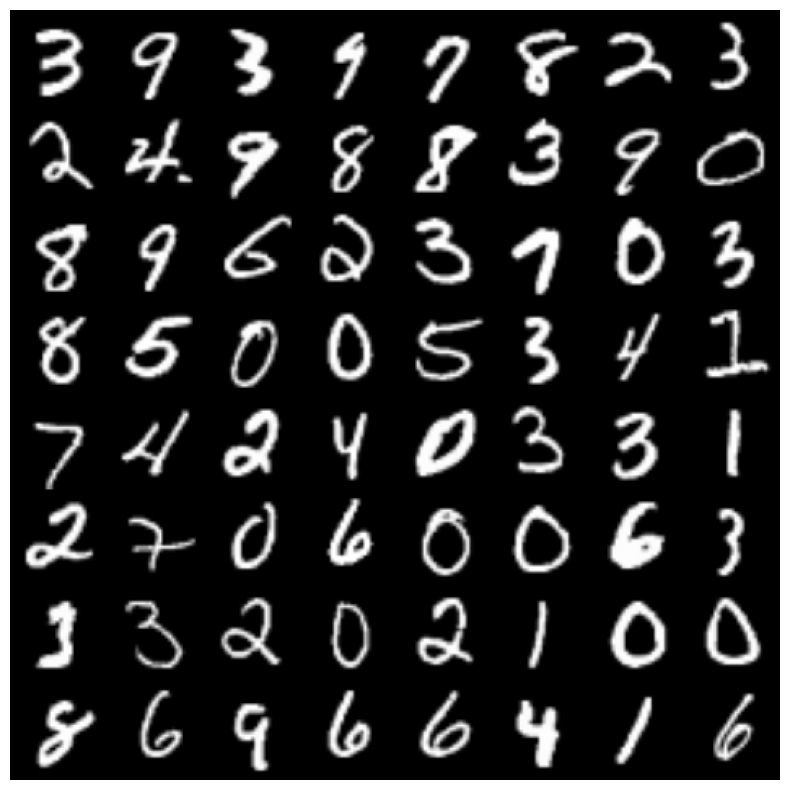

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Visualizing real samples
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
import torch
import torch.nn as nn

nz = 100  # Size of the latent vector (random noise)
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),  # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)  # Output size: [batch, 1, 64, 64]


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),  # Change input channels from 3 to 1
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), 1)

In [ ]:
# Initialize models
generator = Generator(nz)
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

g_loss_log = []
d_loss_log = []

Epoch 10/20: 100%|██████████| 938/938 [01:18<00:00, 11.99it/s, D_Loss=0.0746, G_Loss=6.42]


Epoch [10/20] Loss D: 0.0746, Loss G: 6.4162


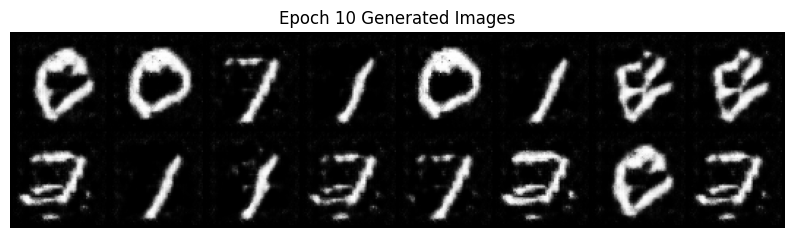

Epoch 20/20: 100%|██████████| 938/938 [01:20<00:00, 11.70it/s, D_Loss=0.0341, G_Loss=6.61]


Epoch [20/20] Loss D: 0.0341, Loss G: 6.6061


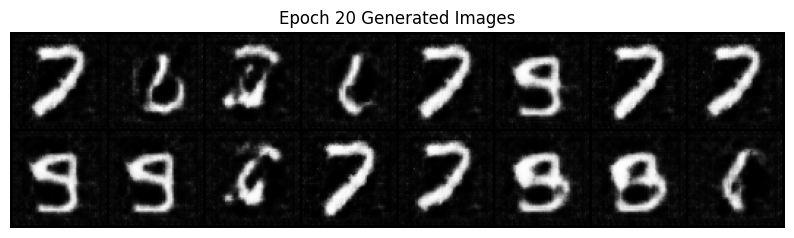

In [ ]:
import tqdm
import numpy as np
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = generator.to(device)
discriminator = discriminator.to(device)

for epoch in range(num_epochs):
    g_losses = []
    d_losses = []

    with tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for i, (real_images, _) in pbar:
            real_images = real_images.to(device)
            current_batch_size = real_images.size(0)

            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            optimizer_D.zero_grad()
            real_outputs = discriminator(real_images)
            real_loss = criterion(real_outputs, real_labels)

            z = torch.randn(current_batch_size, nz, 1, 1).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            fake_loss = criterion(fake_outputs, fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

            g_loss_log.append(g_loss.item())
            d_loss_log.append(d_loss.item())

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            pbar.set_postfix(D_Loss=np.mean(d_losses), G_Loss=np.mean(g_losses))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {np.mean(d_losses):.4f}, Loss G: {np.mean(g_losses):.4f}")

        # Save samples
        with torch.no_grad():
            z = torch.randn(16, nz, 1, 1).to(device)
            sample_images = generator(z)
            grid = vutils.make_grid(sample_images, normalize=True, scale_each=True)
            plt.figure(figsize=(10, 10))
            plt.axis("off")
            plt.title(f"Epoch {epoch+1} Generated Images")
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.show()